Player Clustering  
========
Is it possible to separate AUDL players into groups based on their role and playstyle?

Only 6 of the 24 AUDL teams have rosters with player positions specified, and some teams have different position names than others. These teams may be useful later, but it looks like we do not have suffieicnt information to do traditional classification. Instead we will have to take a clustering/unsupervised learning approach to identify different groups of players. 

__The teams with player positions on their rosters:__  
http://www.myalleycats.com/#!team/c10ek  
http://the-dcbreeze.com/2016-roster-2/  
https://www.laaviators.com/2015-roster/  
http://ottawaoutlaws.com/team/roster/  
http://torontorush.com/club/toronto-rush/  
http://www.sdgrowlers.com/roster/

From the outset, we suspect that AUDL teams follow traditional ultimate schemes where players are split into offense/defense and handlers/cutters. This is the perfect appication for unsupervised clustering, as we expect that these groups exist but we do not have data for all players for it. 

### Playing with sklearn.cluster.KMeans

In [164]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pdb

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets

from scipy.spatial.distance import cdist, euclidean
from scipy.stats import percentileofscore

pd.set_option('display.max_columns', None)

### Processing data

In [7]:
%%bash 
ls South

AtlantaHustle2015-stats.csv
CharlotteExpress2015-stats.csv
JacksonvilleCannons2015-stats.csv
NashvilleNightwatch2015-stats.csv
RaleighFlyers2015-stats.csv


In [8]:
# we'll test all of this with just Raleigh Flyers data
raleigh = pd.read_csv("South/RaleighFlyers2015-stats.csv")

For our k-means algorithm we want an n_item x n_feature matrix where each of the items is a player and each of the features is a statistical parameter that we think will help us cluster. This means that we need to decide what parameters we are interested in. I propose:  
- Percentage of points played that were O points
- Percentage of points where player scores a goal
- Percentage of points where player earns an assist

In [14]:
def clean_df(df):
    """Removes rows with improperly formatted data
    
    df: pandas dataframe with throw-by-throw data
    
    returns: pandas df"""
    
    return df[pd.isnull(df["Player 2"]) == False]


In [15]:
def get_players(df):
    """returns list of all players present in throw-by throw pandas dataframe"""
    players = pd.unique(df.loc[0:, "Player 0": "Player 27"].values.ravel())
    return [player for player in players if not pd.isnull(player)]

In [11]:
get_players(raleigh)

['Snoke D',
 'Bowen J',
 'Tarasi D',
 'Mitche T',
 'Nether J',
 'Dieter B',
 'Casey B',
 'Clark B',
 'Matthe R',
 'Hastin J',
 'Zhou M',
 'Colema J',
 'Snell B',
 'Moore M',
 'Chandl D',
 'McGoog J',
 'Maxsta X',
 'Richar D',
 'Green T',
 'Cretel J',
 'Bender S',
 'Pope T',
 'Allen J',
 'Goode R',
 'Hartzo J',
 'Neve M',
 'Willia J',
 'Saul N',
 'Lin M',
 'McAlis T',
 'Taylor H',
 'Ryan A',
 'Stumpf M',
 'Cooper S',
 'Poulos S',
 'Colicc C',
 'Weeks P',
 '1461',
 '8456',
 'Jessi J']

In [6]:
def summarize_points(df):
    """Gives point-by-point summaries
    
    df: pandas dataframe throw-by-throw data
    
    returns: pandas dataframe"""
    
    return df.groupby(["Date/Time", "Our Score - End of Point", "Their Score - End of Point"]).last().reset_index() 


In [13]:
summarize_points(raleigh).head(3)

,Date/Time,Our Score - End of Point,Their Score - End of Point,Tournamemnt,Opponent,Point Elapsed Seconds,Line,Event Type,Action,Passer,Receiver,Defender,Hang Time (secs),Player 0,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,Player 11,Player 12,Player 13,Player 14,Player 15,Player 16,Player 17,Player 18,Player 19,Player 20,Player 21,Player 22,Player 23,Player 24,Player 25,Player 26,Player 27,Elapsed Time (secs)
0,2015-04-11 18:59,0,1,AUDL,Atlanta Hustle,16,D,Defense,Goal,NaN,NaN,Anonymous,4,Clark B,Matthe R,Green T,Cretel J,Zhou M,Bender S,Pope T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,2015-04-11 18:59,0,2,AUDL,Atlanta Hustle,41,O,Defense,Goal,Allen J,Anonymous,Anonymous,NaN,Bowen J,Snoke D,Mitche T,Tarasi D,Dieter B,Casey B,Allen J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
2,2015-04-11 18:59,1,2,AUDL,Atlanta Hustle,65,O,Offense,Goal,Snoke D,Neve M,Anonymous,NaN,Snoke D,Goode R,Tarasi D,Chandl D,Neve M,Cretel J,Allen J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225


In [115]:
def player_summaries(df):
    """Summarize statistics for all players
    
    df: pandas dataframe with throw-by-throw data
    
    returns: pandas dataframe"""
    
    players = get_players(df)
    stats = {"team"      : "",
             "goals"     : 0,
             "assists"   : 0,
             "ds"        : 0,
             "throwaways": 0,
             "drops"     : 0,
             "opoints"   : 0,
             "dpoints"   : 0}
    team_stats = {player: dict(stats) for player in players}
    
    # does not mutate the original
    df = clean_df(df)
    
    # add goals and assists
    ogoals = df[(df.Action == "Goal") & (df["Event Type"] == "Offense")]
    for row in ogoals.values:
        # we have try/execpt here for unpredictable data impurities
        # eg: "Anonymous" for one of the assists, stat-keeper must
        # have not known who threw it (?)
        try: team_stats[row[9]]["assists"] += 1
        except: pass
        try: team_stats[row[10]]["goals"]  += 1
        except: pass
        
    # add D's
    ds = df.Defender[df.Action == "D"]
    for player in ds:
        try: team_stats[player]["ds"] += 1
        except: pass
        
        
    # add turnovers and drops
    turns = df[((df.Action == "Throwaway") & (df["Event Type"] == "Offense")) | (df.Action == "Drop") ]
    for row in turns.values:
        if row[8] == "Throwaway":
            try: team_stats[row[9]]["throwaways"] += 1
            except: pass
        else:
            try: team_stats[row[10]]["drops"]     += 1
            except: pass
            
    # add points
    for row in summarize_points(df).values:
        player_cols = row[13:41]
        players = [player for player in player_cols if not pd.isnull(player)]
        if row[6] == "O":
            for player in players:
                team_stats[player]["opoints"] += 1
        else:
            for player in players:
                team_stats[player]["dpoints"] += 1
                
    summary = pd.DataFrame.from_dict(team_stats, orient="index").sort_values("goals", ascending=False)
    summary = summary[["team", "goals", "assists", "ds", "throwaways", "drops", "opoints", "dpoints"]]
    summary["totalpoints"] = summary["opoints"] + summary["dpoints"]
    summary["pct_opoints"] = summary["opoints"] / [float(x) for x in summary["totalpoints"]]
    summary["pct_goal"]    = summary["goals"]   / [float(x) for x in summary["totalpoints"]]
    summary["pct_assist"]  = summary["assists"] / [float(x) for x in summary["totalpoints"]]
    summary["pct_d"]       = summary["ds"]      / [float(x) for x in summary["totalpoints"]]
    
    return summary

In [15]:
summary_ral = player_summaries(raleigh)
summary_ral.head()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d
Allen J,62,60,14,35,5,299,119,418,0.715311,0.148325,0.143541,0.033493
Bowen J,62,49,7,27,10,287,50,337,0.851632,0.183976,0.145401,0.020772
Mitche T,26,21,12,25,9,283,83,366,0.773224,0.071038,0.057377,0.032787
Snoke D,25,29,11,12,2,254,39,293,0.866894,0.085324,0.098976,0.037543
Neve M,25,12,12,6,3,159,86,245,0.648980,0.102041,0.048980,0.048980


We now have the matrix with the preliminary statistics we want to cluster on. Let's try kmeans and see what we can see.

In [16]:
cluster_cols = summary_ral[["totalpoints", "pct_opoints", "pct_goal", "pct_assist"]]
model = KMeans(n_clusters=5).fit(cluster_cols.values)
summary_ral["cluster"] = model.labels_
summary_ral.groupby("cluster").count()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d
cluster,,,,,,,,,,,,
0,9,9,9,9,9,9,9,9,9,9,9,9
1,16,16,16,16,16,16,16,16,16,16,16,16
2,6,6,6,6,6,6,6,6,6,6,6,6
3,3,3,3,3,3,3,3,3,3,3,3,3
4,6,6,6,6,6,6,6,6,6,6,6,6


In [17]:
summary_ral.groupby("cluster").mean()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d
cluster,,,,,,,,,,,,
0,9.000000,10.222222,8.888889,8.333333,2.111111,47.000000,167.222222,214.222222,0.231227,0.041778,0.049304,0.040945
1,2.375000,1.375000,2.437500,1.375000,0.562500,6.500000,32.000000,38.500000,0.287504,0.051854,0.029672,0.050820
2,17.166667,24.000000,9.333333,13.333333,2.833333,161.166667,112.166667,273.333333,0.588363,0.063496,0.087144,0.034113
3,50.000000,43.333333,11.000000,29.000000,8.000000,289.666667,84.000000,373.666667,0.780056,0.134447,0.115439,0.029017
4,8.500000,5.833333,3.333333,5.166667,1.666667,58.166667,69.666667,127.833333,0.457130,0.066777,0.045453,0.026462


Let's try to use the elbow method to see what the optimal number of clusters is

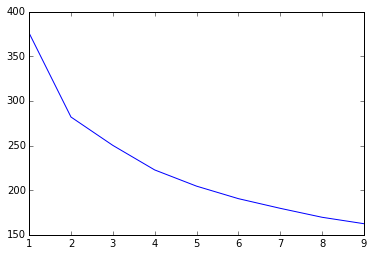

In [113]:
num_clusters = range(1, 10)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)


## Trying all of this with team-combined csv

In [116]:
combined = pd.read_csv("combined.csv")
combined = clean_df(combined)
combined = combined.drop("Unnamed: 0", axis=1)

In [138]:
all_players = player_summaries(combined)
all_players["goal_percentile"] = [percentileofscore(all_players["pct_goal"], x) / 100.0 for x in all_players["pct_goal"]]
all_players["assist_percentile"] = [percentileofscore(all_players["pct_assist"], x) / 100.0 for x in all_players["pct_assist"]]
cluster_cols = all_players[["pct_opoints", "goal_percentile", "assist_percentile"]]

After reading in the data we'll use k-means to create player clusters. We will first explore using the elbow method to see if there is an optimal number of clusters.

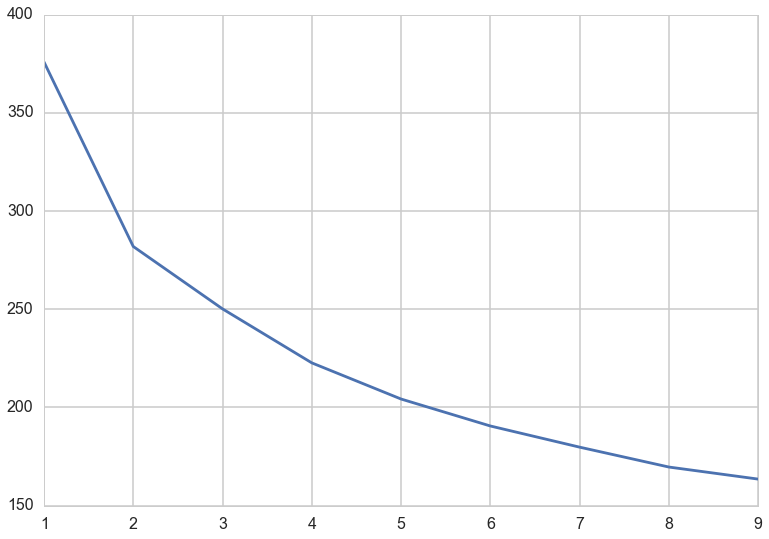

In [174]:
num_clusters = range(1, 10)
models = [KMeans(n_clusters = x) for x in num_clusters]
def score_from_model(model):
    predicted = model.fit_predict(cluster_cols.values)
    centroids = [model.cluster_centers_[x] for x in predicted]
    dist_sum = 0
    for i in range(0, len(predicted)):
        dist_sum += euclidean(cluster_cols.values[i], centroids[i])
    return dist_sum
scores = [score_from_model(model) for model in models]
scores

plt.plot(num_clusters, scores)

There doesn't seem to be an obvious "elbow" for us to separate clusters into. We know we want at least four (offensive handler, offensive cutter, defensive handler, defensive cutter), so that should be a lower bound. Let's take a look at what the clusters end up being for a few cases.

### 4-cluster model

In [141]:
model = KMeans(n_clusters=4).fit(cluster_cols.values)
all_players["cluster"] = model.labels_
all_players.groupby("cluster").count().iloc[0:, 0]

cluster
0    193
1    223
2    147
3    214
Name: team, dtype: int64

In [142]:
all_players.groupby("cluster").mean()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile
cluster,,,,,,,,,,,,,,
0,23.585492,20.746114,6.896373,15.129534,3.678756,153.911917,49.611399,203.523316,0.754751,0.115462,0.099153,0.033632,0.805409,0.745297
1,2.632287,3.569507,4.085202,4.726457,1.103139,20.865471,84.551570,105.417040,0.196209,0.021232,0.027711,0.035322,0.210840,0.281279
2,5.448980,14.312925,5.034014,15.564626,2.047619,113.653061,55.496599,169.149660,0.680433,0.030852,0.082275,0.028458,0.294684,0.651354
3,11.112150,6.574766,7.831776,6.037383,1.714953,36.369159,105.070093,141.439252,0.242126,0.082551,0.042703,0.049908,0.669253,0.405063


### 5-cluster model

In [143]:
model = KMeans(n_clusters=5).fit(cluster_cols.values)
all_players["cluster"] = model.labels_
all_players.groupby("cluster").count().iloc[0:, 0]

cluster
0    134
1    185
2    181
3    168
4    109
Name: team, dtype: int64

In [144]:
all_players.groupby("cluster").mean()

,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile
cluster,,,,,,,,,,,,,,
0,6.880597,13.052239,7.574627,11.059701,1.626866,42.932836,118.194030,161.126866,0.255416,0.041971,0.081144,0.043754,0.384386,0.697315
1,2.567568,2.405405,3.805405,3.918919,1.081081,19.767568,78.518919,98.286486,0.198198,0.021188,0.020304,0.034860,0.211273,0.215180
2,23.580110,21.342541,6.861878,15.397790,3.679558,155.801105,48.430939,204.232044,0.760146,0.115774,0.101744,0.033413,0.807590,0.761844
3,12.202381,4.511905,7.333333,4.964286,1.797619,41.857143,94.232143,136.089286,0.278680,0.091091,0.029575,0.049005,0.711746,0.300948
4,5.532110,13.724771,4.266055,15.834862,2.183486,130.330275,37.724771,168.055046,0.788653,0.031358,0.078307,0.024208,0.299629,0.617418


As we can see from the two summaries above, there are clear offensive handlers and cutters from both models (hight % opoints, cutters have high assist and goal percentages, handlers have high assist percentage). However, the breakdown seems to be not as clear for defensive players. In the 4-cluster model, there are clear defensive cutters, but the 4th cluster seems to be role-players (they do not have high assist % or goal %). The 5-cluster model creates 3 defensive player groups, one with role players, one with handlers, and one with cutters. We will go with this 5-cluster group for our model.

In [145]:
# defining clusters in plaintext
all_players.cluster[all_players.cluster == 0] = "d_handler"
all_players.cluster[all_players.cluster == 1] = "d_roleplayer"
all_players.cluster[all_players.cluster == 2] = "o_cutter"
all_players.cluster[all_players.cluster == 3] = "d_cutter"
all_players.cluster[all_players.cluster == 4] = "o_handler"

C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


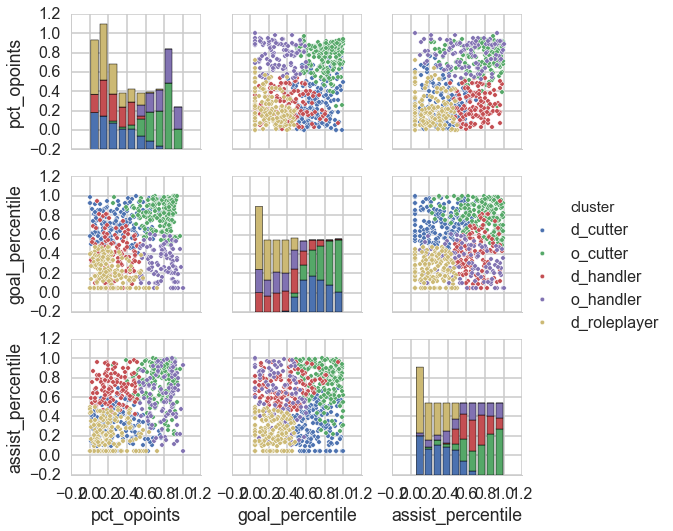

In [146]:
sns.pairplot(all_players, vars=["pct_opoints", "goal_percentile", "assist_percentile"], hue="cluster")

Investigating our clusters above we can see a few things. One of the first is that our suspicion about offensive/defensive players: we can see that the histogram for percentage of offensive points played is bimodal, with players tending to play their points on one particular side of the disc. We can also see the large group of defensive role players in the bottom corner of the plot. While it is unfortunate for classification that we cannot really tell if these players are handlers of cutters, it is necessary to do a 5-cluster model so that we have some method of identifying defensive handlers.

We also observe a very uniform distribution for the assist and goal percentiles - this is to be expected due to the nature of the fact that we trandformed the data into a percentile scale. Let's examine the data without the transformation.

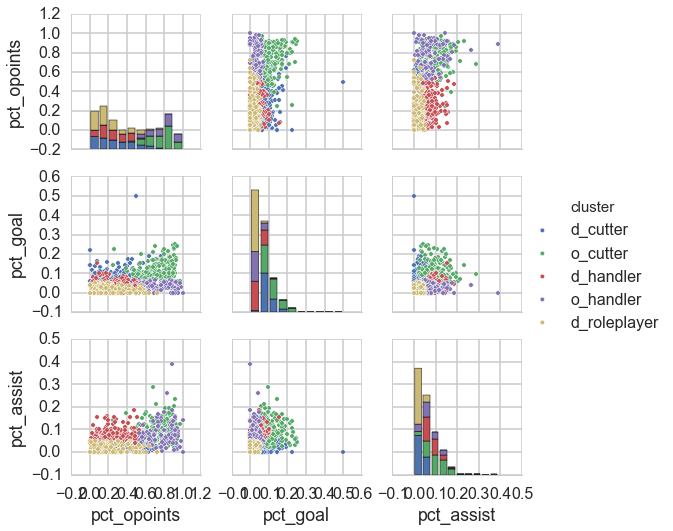

In [175]:
sns.pairplot(all_players, vars=["pct_opoints", "pct_goal", "pct_assist"], hue="cluster")

It is interesting to note that all of these data are very right-skewed. The majority of players have very low goal and assist percentages. This shows that the best players are racking up most of the goals and assists.

Another interesting observation lies within our "offensive cutter" cluster. This cluster not only has a high percentage of goals, but also a high percentage of assists. This goes to show that the best players at the profssional level are skilled on both sides of the disc. We can look at some of the best offensive cutters to see that they are both goal scoring and assist making machines.

In [158]:
# top offensive cutters also tend to be great throwers
all_players.loc[["Kittre B", "Allen J", "DeGiro T"], ]

,team,goals,assists,ds,throwaways,drops,opoints,dpoints,totalpoints,pct_opoints,pct_goal,pct_assist,pct_d,goal_percentile,assist_percentile,cluster
Kittre B,,68,37,26,23,3,263,153,416,0.632212,0.163462,0.088942,0.062500,0.954955,0.777349,o_cutter
Allen J,,62,60,14,35,5,299,119,418,0.715311,0.148325,0.143541,0.033493,0.934363,0.934363,o_cutter
DeGiro T,,28,86,13,19,3,203,95,298,0.681208,0.093960,0.288591,0.043624,0.777992,0.998713,o_cutter
